<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Загрузка-данных" data-toc-modified-id="Загрузка-данных-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Загрузка данных</a></span></li><li><span><a href="#Умножение-матриц" data-toc-modified-id="Умножение-матриц-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Умножение матриц</a></span></li><li><span><a href="#Алгоритм-преобразования" data-toc-modified-id="Алгоритм-преобразования-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Алгоритм преобразования</a></span></li><li><span><a href="#Проверка-алгоритма" data-toc-modified-id="Проверка-алгоритма-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Проверка алгоритма</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

# Защита персональных данных клиентов

Вам нужно защитить данные клиентов страховой компании «Хоть потоп». Разработайте такой метод преобразования данных, чтобы по ним было сложно восстановить персональную информацию. Обоснуйте корректность его работы.

Нужно защитить данные, чтобы при преобразовании качество моделей машинного обучения не ухудшилось. Подбирать наилучшую модель не требуется.

## Загрузка данных

Перед началом работы сделаем импорт необходимых бибилиотек.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display
import seaborn as sns
import numpy as np
import warnings
import re

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score

Загрузим данные страховой компании и посмотрим на них.

In [2]:
df = pd.read_csv('/datasets/insurance.csv')
df.columns = ['gender', 'age', 'sale', 'family_member', 'insurance']
df.sample(3)

,gender,age,sale,family_member,insurance
2875,1,35.0,40500.0,3,0
1792,1,33.0,30700.0,1,0
3776,1,20.0,42200.0,1,0


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   gender         5000 non-null   int64  
 1   age            5000 non-null   float64
 2   sale           5000 non-null   float64
 3   family_member  5000 non-null   int64  
 4   insurance      5000 non-null   int64  
dtypes: float64(2), int64(3)
memory usage: 195.4 KB


In [4]:
df.describe(include = 'all').round(1)

,gender,age,sale,family_member,insurance
count,5000.0,5000.0,5000.0,5000.0,5000.0
mean,0.5,31.0,39916.4,1.2,0.1
std,0.5,8.4,9900.1,1.1,0.5
min,0.0,18.0,5300.0,0.0,0.0
25%,0.0,24.0,33300.0,0.0,0.0
50%,0.0,30.0,40200.0,1.0,0.0
75%,1.0,37.0,46600.0,2.0,0.0
max,1.0,65.0,79000.0,6.0,5.0


In [5]:
df = df.convert_dtypes()
df.dtypes

gender             Int64
age                Int64
sale             Float64
family_member      Int64
insurance          Int64
dtype: object

In [6]:
df.isna().sum()

gender           0
age              0
sale             0
family_member    0
insurance        0
dtype: int64

In [7]:
print(f'Find {df.duplicated().sum()} duplicate in a DataFrame')

Find 153 duplicate in a DataFrame


In [8]:
df = df.drop_duplicates()

In [9]:
df.corr().style.background_gradient(cmap='coolwarm', 
                                    axis=None, 
                                    vmin=df.corr().min().min(), 
                                    vmax=df.corr().max().max()).set_precision(3)

,gender,age,sale,family_member,insurance
gender,1.000,0.002,0.015,-0.007,0.012
age,0.002,1.000,-0.017,-0.009,0.655
sale,0.015,-0.017,1.000,-0.032,-0.013
family_member,-0.007,-0.009,-0.032,1.000,-0.039
insurance,0.012,0.655,-0.013,-0.039,1.000


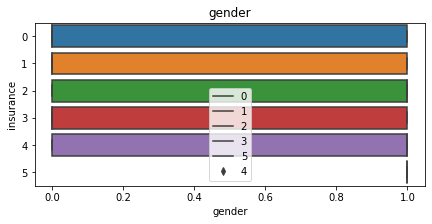

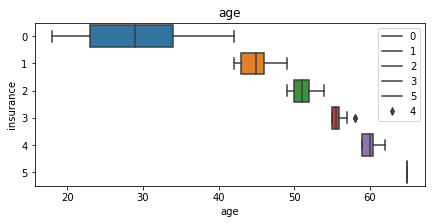

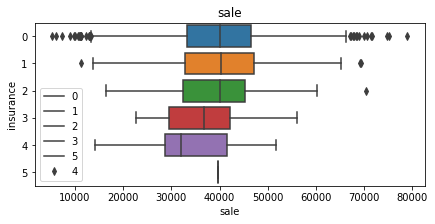

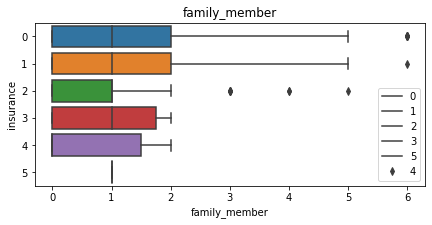

In [10]:
df_1 = df.drop(columns = ['insurance'], axis=1)
for i, col in enumerate(df_1):
    fig, ax = plt.subplots(figsize=(7,3))
    sns.boxplot(data = df, x = col, y = 'insurance', orient = 'h')
    plt.title(str(col))
    plt.legend(labels=df['insurance'].unique())
    plt.show()

В нашем рапоряжении 5k записей страховой компании:
- `признаки`: пол клиента, его возраст, заработная плата и количество членов семьи
- `целевой признак`: количество страховых платежей.

Пропусков в данных нет, обнаружено 153 дубликата по строкам, а также скорректирован тип данных по признакому возраст.

Средний возраст клиента страховой компании - 31 год (варьируется от 18 до 65 лет), в среднем получает до 40k д.е. и имеет одного чдена семьи.

Как и следовало ожидать, на количество страховых выплат непосредтсвенно влияент возраст клиента, остальные признаки почти не имеют влияния.

## Умножение матриц

Признаки умножают на обратимую матрицу. 
Изменится ли качество линейной регрессии? Давайте посмотри на вычисления.

Обозначения:

- $X$ — матрица признаков (нулевой столбец состоит из единиц)

- $y$ — вектор целевого признака

- $P$ — матрица, на которую умножаются признаки

- $w$ — вектор весов линейной регрессии (нулевой элемент равен сдвигу)

Предсказания:

$$
a = Xw                        
$$

Задача обучения:

$$
w = \arg\min_w MSE(Xw, y) 
$$

Формула обучения:

$$
w = (X^T X)^{-1} X^T y 
$$

Пусть X1 - новая матрица, полученная в ходе преоизведения исходной матрицы X на обратимую P:

$$
X_1 = XP
$$

Тогда формула обучения w_1 будет выглядеть следующим образом:

$$
w_1 = ((XP)^T XP)^{-1} (XP)^T y
$$

Упростим выражение, раскрыв скобки:
$$
w_1 = (P^T X^TXP)^{-1} X^T P^T y
$$

Тогда:
$$
w_1 = P^{-1}(X^TX)^{-1}(P^T)^{-1}P^TX^Ty
$$

А так как матрица $P$ обратная, то произведение $ (P^T)^{-1}P^T $ равно единичной матрице  $E$, поэтому $$w_1 = P^{-1}(X^TX)^{-1}EX^Ty = P^{-1}(X^TX)^{-1}X^Ty = P^{-1}w $$

Итого, предсказания равны:
$$
a_1 = X_1w_1 = XP P^{-1}w
$$

Так как $P P^{-1}$ равно $E$, то:
$$
a_1 = XEw = Xw = a
$$


**Ответ:** При умножении признаков на обратимую матрицу, предсказания модели не поменяется ($a_1 = a$), но поменяются веса для новых признаков ($w_1 = P^{-1}w $).

## Алгоритм преобразования

Как уже отметили выше, чтобы защитить данные и при этом не потерять качество модели ML, нужно умножить признакми модели на обратимую матрицу P.

Для этого выделим создадим рандомную матрицу нужной размерности и умножим на нее матрицу признаков.

In [11]:
def encryption(X):
    random_matrix = np.random.randint(100,size = (4, 4))
    X_new = X @ random_matrix
    return X_new

Выделим в исходной матрице признаки `X` и целефой признак `y`, сделаем масштабирование признаков с помощью метода StandardScaler() и сохраним их:

In [12]:
X = df.drop('insurance', axis = 1)
y = df.insurance
 
scaler = StandardScaler()
scaler.fit(X)

X_scaled = scaler.transform(X)

По формулам из п.2 найдем веса $w$ для исходных признаков X_scaled и сами предсказания:

In [13]:
def pred(X,y, show = False):
    w = np.linalg.inv(X.T.dot(X)).dot(X.T).dot(y)
    a = X @ w
    if show:
        print(f'Весы: {w}')
        print()
        print(f'Предсказания: {a}')
    return w,a

In [14]:
w, a = pred(X_scaled, y, True)

Весы: [0.004730068054176864 0.3069282623466504 -0.001386011472040633
 -0.015656252287099333]

Предсказания: [0.3670696788885955 0.5400418375579217 -0.058131709105968224 ...
 -0.413904244286536 -0.34620099419464073 -0.10181150352920469]


Настало время преобразовать признаки с помощью умножения на производную матрицу функцией `encryption`, нахождения новых весов и предсказаний. Выполним такую магию раз 10:

In [15]:
for i in range(1,10):
    X_scaled_new = encryption(X_scaled)
    w1, a1 = pred(X_scaled_new, y, False)
    diff = (a - a1).sum()
    print(diff)

-2.4522918418146133e-14
-8.4519197196542e-14
-5.323692875425223e-14
-2.048118619146777e-13
1.5680685916397152e-13
1.0061396160665481e-15
8.833159897969622e-13
-4.5982315177717226e-14
-4.380610457710432e-14


Видно, что расхождения очень малы, ими можно пренебречь. Следовательно, получилось доказать, что алгоритм защиты данных не меняет качество модели.

## Проверка алгоритма

Проверим, что качество линейной регрессии не имезнится до и после применения алгоритма.

In [16]:
def model_LR(X, y):
    model = LinearRegression().fit(X, y)
    predictions = model.predict(X)
    mse = mean_squared_error(y, predictions)
    print('MSE Score:', mse)
    print('R2_Score: ', r2_score(y, predictions))

In [17]:
print('Исходная выборка:')
model_LR(X_scaled, y)

Исходная выборка:
MSE Score: 0.12527263826681603
R2_Score:  0.4302010044852067


/opt/conda/lib/python3.9/site-packages/sklearn/utils/validation.py:63: FutureWarning: Arrays of bytes/strings is being converted to decimal numbers if dtype='numeric'. This behavior is deprecated in 0.24 and will be removed in 1.1 (renaming of 0.26). Please convert your data to numeric values explicitly instead.
  return f(*args, **kwargs)
/opt/conda/lib/python3.9/site-packages/sklearn/utils/validation.py:63: FutureWarning: Arrays of bytes/strings is being converted to decimal numbers if dtype='numeric'. This behavior is deprecated in 0.24 and will be removed in 1.1 (renaming of 0.26). Please convert your data to numeric values explicitly instead.
  return f(*args, **kwargs)


Используем алгоритм преобразования данных:

In [18]:
print('Закодированная выборка:')
model_LR(encryption(X_scaled), y)

/opt/conda/lib/python3.9/site-packages/sklearn/utils/validation.py:63: FutureWarning: Arrays of bytes/strings is being converted to decimal numbers if dtype='numeric'. This behavior is deprecated in 0.24 and will be removed in 1.1 (renaming of 0.26). Please convert your data to numeric values explicitly instead.
  return f(*args, **kwargs)
/opt/conda/lib/python3.9/site-packages/sklearn/utils/validation.py:63: FutureWarning: Arrays of bytes/strings is being converted to decimal numbers if dtype='numeric'. This behavior is deprecated in 0.24 and will be removed in 1.1 (renaming of 0.26). Please convert your data to numeric values explicitly instead.
  return f(*args, **kwargs)


Закодированная выборка:
MSE Score: 0.12527263826681603
R2_Score:  0.4302010044852067
